In [96]:
# Machine learning classification libraries
from sklearn.svm import SVC
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [97]:
AAPL_data = pd.read_csv('./rsc/AAPL_data.csv')
AAPL_data = AAPL_data.dropna()

In [98]:
# +1 means buy -1 means hold
# use this to evalute whether the algorithm can tell whether to buy or hold
y = np.where(AAPL_data['close'].shift(-1) > AAPL_data['close'],1,-1)
print(y[0:10])

[ 1  1  1  1 -1  1  1  1  1  1]


In [99]:
print(AAPL_data.columns[1:len(AAPL_data)])

Index(['20_day_sma', 'close', 'ewma_12', 'ewma_26', 'high', 'low', 'obv_10',
       'open', 'rsi_14', 'volume'],
      dtype='object')


In [100]:
# X dataset contains predictor variables to predict target variable y
# 
AAPL_data['Open-Close'] = AAPL_data.open - AAPL_data.close
AAPL_data['High-Low'] = AAPL_data.high - AAPL_data.low
 
X=AAPL_data[AAPL_data.columns[1:]]

In [101]:
split_percentage = 0.8
split = int(split_percentage*len(AAPL_data))

# Train data set
X_train = X[:split]
y_train = y[:split]
 
# Test data set
X_test = X[split:]
y_test = y[split:]

In [102]:
cls = SVC().fit(X_train, y_train)

In [103]:
# compare accuracy by comparing actual values of trading signal with predicted values of trading signal
#
accuracy_train = accuracy_score(y_train, cls.predict(X_train))
 
accuracy_test = accuracy_score(y_test, cls.predict(X_test))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 100.00%
Test Accuracy: 52.78%


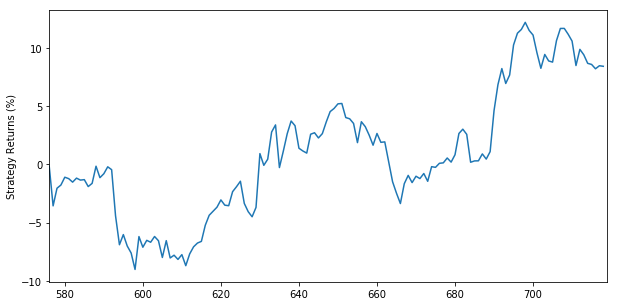

In [104]:
# predict the buy/sell signals of the test dataset
# evalute against the model in the train dataset in the next day
AAPL_data['Predicted_Signal'] = cls.predict(X)
 
# Calculate log returns
AAPL_data['Return'] = np.log(AAPL_data.close.shift(-1) / AAPL_data.close)*100
AAPL_data['Strategy_Return'] = AAPL_data.Return * AAPL_data.Predicted_Signal
AAPL_data.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [105]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [114]:
def classification_model(model, data, predictors, outcome):
    # fit the model
    model.fit(data[predictors], outcome)
    
    # Make predictions on the training set
    predictions = model.predict(data[predictors])
    
    # Print accuracy
    accuracy = accuracy_score(predictions, outcome)
    print("Accuracy : %s" % "{0:.2%}".format(accuracy))
    
     # Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=5)
    error = []
    for train, test in kf.split(outcome):
        # Filter training data
        train_predictors = (data[predictors].iloc[train, :])

        # The target we're using to train the algorithm.
        train_target = outcome[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        # Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test, :], outcome[test]))

        print("Cross-Validation Score : %s" % "{0:.2%}".format(np.mean(error)))

    # Fit the model again so that it can be referred outside the function:
    model.fit(data[predictors], outcome)

    

In [115]:
AAPL_data = pd.read_csv('./rsc/AAPL_data.csv')
AAPL_data = AAPL_data.dropna()

In [123]:
# Random Forest Classifier all features
# Use all the features of the nucleus

predictor_var = AAPL_data.columns[1:len(AAPL_data)]
outcome_var = y
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, AAPL_data, predictor_var, outcome_var)

Accuracy : 76.39%
Cross-Validation Score : 62.50%
Cross-Validation Score : 62.15%
Cross-Validation Score : 62.04%
Cross-Validation Score : 62.33%
Cross-Validation Score : 62.22%


In [124]:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

obv_10        0.271281
rsi_14        0.199507
volume        0.085943
close         0.068843
ewma_26       0.068001
high          0.067302
20_day_sma    0.063301
ewma_12       0.062951
low           0.058627
open          0.054243
dtype: float64


In [130]:
# predict the buy/sell signals of the test dataset
# evaluate against the model in the train dataset
AAPL_data['Predicted_Signal'] = model.predict(AAPL_data[predictor_var])

# Calculate log returns
AAPL_data['Return'] = np.log(AAPL_data.close.shift(-1) / AAPL_data.close)*100
AAPL_data['Strategy_Return'] = AAPL_data.Return * AAPL_data.Predicted_Signal

AAPL_data.set_index('date',inplace=True)
AAPL_data.head()

,20_day_sma,close,ewma_12,ewma_26,high,low,obv_10,open,rsi_14,volume,Predicted_Signal,Return,Strategy_Return
date,,,,,,,,,,,,,
2015-01-30,110.6415,117.16,113.100715,111.782535,120.00,116.850,36869040.5,118.40,91.43,83745461.0,1,1.246888,1.246888
2015-02-02,111.1065,118.63,113.977641,112.415496,119.17,116.080,37070624.7,118.05,92.46,62739100.0,1,0.016858,0.016858
2015-02-03,111.7265,118.65,114.715157,112.981405,119.09,117.610,39228009.3,118.50,88.13,51915749.0,1,0.764035,0.764035
2015-02-04,112.3915,119.56,115.476853,113.568741,120.51,118.309,38072992.9,118.50,72.85,70149743.0,1,0.317328,0.317328
2015-02-05,113.0010,119.94,116.176181,114.129045,120.23,119.250,29055853.4,120.02,74.42,42246245.0,1,-0.845653,-0.845653


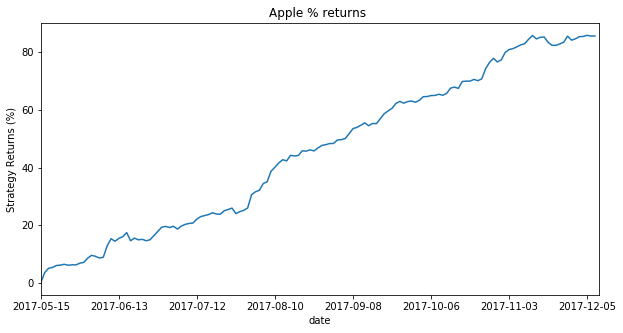

In [131]:
AAPL_data.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.title('Apple % returns ')
plt.show()